In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch
import torch.nn.functional as F
import hydra
from hydra import compose
from hydra.core.global_hydra import GlobalHydra
from utils import process_input, process_output, slice_nms
from inference import postprocess, merge_multiclass_masks

from skimage import segmentation
from skimage.measure import label

### Load BiomedParse Model

In [21]:
from huggingface_hub import hf_hub_download

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

GlobalHydra.instance().clear()
hydra.initialize(config_path="configs/model", job_name="example_prediction")
cfg = compose(config_name="biomedparse_3D")
model = hydra.utils.instantiate(cfg, _convert_="object")
model.load_pretrained(hf_hub_download(
  repo_id="microsoft/BiomedParse", filename="biomedparse_v2.ckpt"))
model = model.to(device).eval()

Using device: cuda


/tmp/ipykernel_3862814/1552876500.py:7: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path="configs/model", job_name="example_prediction")
/home/theodorezhao/miniconda3/envs/biomedparse/lib/python3.9/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'biomedparse_3D': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
/datadrive/BiomedParse/src/model/biomedparse_3D.py:393: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future rel

Checkpoint loaded successfully!


### Example 3D Image Data

In [22]:
file_path = "examples/imgs/CT_AMOS_amos_0018.npz"
gt_path = file_path.replace("imgs", "gts")

npz_data = np.load(file_path, allow_pickle=True)
image = npz_data["imgs"]
text_prompts = npz_data["text_prompts"].item()

gt_data = np.load(gt_path)
gt_masks = gt_data["gts"]

print("Loaded image shape:", image.shape)
print("Text prompts:", text_prompts)

Loaded image shape: (63, 512, 512)
Text prompts: {'1': 'CT imaging of the spleen within the abdomen', '2': 'Presence of the right kidney detected in abdominal CT images', '3': 'Abdominal CT showing the left kidney', '4': 'CT scan of the gallbladder in the abdominal region', '5': 'CT scan of the esophagus in the abdominal region', '6': 'Visualization of the liver in abdominal CT imaging', '7': 'CT imaging of the stomach in the abdomen', '8': 'Abdominal CT showing aortic structures', '9': 'Inferior vena cava in abdominal CT', '10': 'CT scan of the pancreas in the abdominal region', '11': 'CT imaging of the right adrenal gland in the abdomen', '12': 'CT imaging of the left adrenal gland in the abdomen', '13': 'Visualization of the duodenum in abdominal CT imaging', '14': 'Bladder observed in abdominal CT scans', '15': 'CT scan of the prostate/uterus in the abdominal region', 'instance_label': 0}


In [23]:
ids = [int(_) for _ in text_prompts.keys() if _ != "instance_label"]
ids.sort()
text = "[SEP]".join([text_prompts[str(i)] for i in ids])

imgs, pad_width, padded_size, valid_axis = process_input(image, 512)

imgs = imgs.to(device).int()

input_tensor = {
    "image": imgs.unsqueeze(0),  # Add batch dimension
    "text": [text],
}

### Model Inference and Processing

In [24]:
with torch.no_grad():
    output = model(input_tensor, mode="eval", slice_batch_size=4)

mask_preds = output["predictions"]["pred_gmasks"]
mask_preds = F.interpolate(mask_preds, size=(512, 512), mode="bicubic", align_corners=False, antialias=True)

mask_preds = postprocess(mask_preds, output["predictions"]["object_existence"])
mask_preds = merge_multiclass_masks(mask_preds, ids)
mask_preds = process_output(mask_preds, pad_width, padded_size, valid_axis)
print("Processed mask shape:", mask_preds.shape)

Processed mask shape: (63, 512, 512)


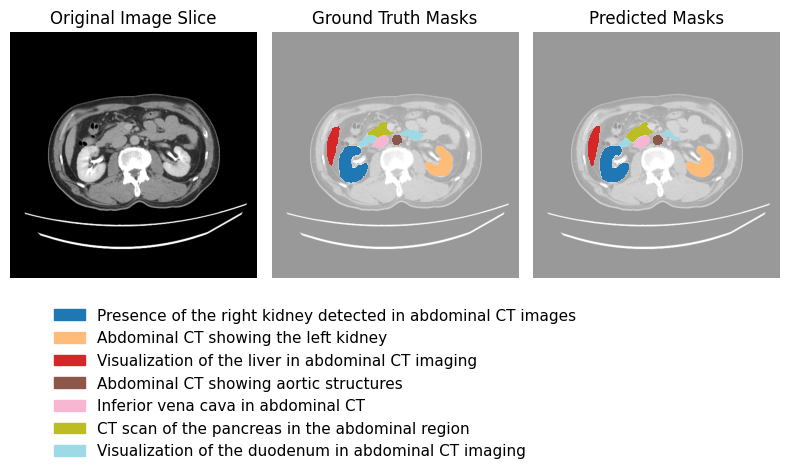

In [25]:
slice_id = 30
slice_image = image[slice_id]
slice_mask = mask_preds[slice_id]
slice_gt   = gt_masks[slice_id]

rotate = 2
slice_image = np.rot90(slice_image, k=rotate)
slice_gt = np.rot90(slice_gt, k=rotate)
slice_mask = np.rot90(slice_mask, k=rotate)

flip = True
if flip:
    slice_image = np.flip(slice_image, axis=1)
    slice_gt = np.flip(slice_gt, axis=1)
    slice_mask = np.flip(slice_mask, axis=1)

if text_prompts['instance_label'] == 1:
    # If instance_label is 1, we assume it is a binary mask
    slice_gt   = slice_gt > 0

# 1) Compute the mapping
unique_ids = np.unique(np.concatenate((slice_mask, slice_gt)))
id_map = {orig_id: new_i for new_i, orig_id in enumerate(unique_ids)}

slice_mask_mapped = np.vectorize(id_map.get)(slice_mask)
slice_gt_mapped   = np.vectorize(id_map.get)(slice_gt)

slice_mask_mapped = np.ma.masked_where(slice_mask_mapped == 0, slice_mask_mapped)
slice_gt_mapped = np.ma.masked_where(slice_gt_mapped == 0, slice_gt_mapped)

# 2) Which IDs to show (drop background=0)
mask_ids = unique_ids[1:]

# 3) Labels for legend
legends = [text_prompts[str(i)] for i in mask_ids if str(i) in text_prompts]
mask_ids = [i for i in mask_ids if str(i) in text_prompts]

# 4) Build a *discrete* colormap of size len(unique_ids)
#    so that cmap(k) gives exactly the k-th color.
cmap = plt.get_cmap('tab20', len(unique_ids)-1)

# 5) Create handles using integer lookup into the discrete cmap
handles = [
    mpatches.Patch(color=cmap(id_map[i]-1), label=txt)
    for i, txt in zip(mask_ids, legends)
]

# 6) Plot
fig, axes = plt.subplots(1, 3, figsize=(8, 5))

axes[0].imshow(slice_image, cmap="gray")
axes[0].set_title("Original Image Slice")
axes[0].axis("off")

axes[1].imshow(slice_image, cmap='gray', alpha=0.4)
axes[1].imshow(slice_gt_mapped, cmap=cmap, interpolation='nearest')
axes[1].set_title("Ground Truth Masks")
axes[1].axis("off")

axes[2].imshow(slice_image, cmap='gray', alpha=0.4)
axes[2].imshow(slice_mask_mapped, cmap=cmap, interpolation='nearest')
axes[2].set_title("Predicted Masks")
axes[2].axis("off")

# 7) Shared legend below, single column
fig.legend(handles, legends, loc='lower center', bbox_to_anchor=(0.4, -0.15), ncol=1, frameon=False, fontsize=11)

plt.tight_layout()
plt.subplots_adjust(bottom=0)
plt.show()

### Instance Segmentation

In [26]:
file_path = "examples/imgs/Microscopy_SELMA3D_patchvolume_nuclei_004.npz"
gt_path = file_path.replace("imgs", "gts")

npz_data = np.load(file_path, allow_pickle=True)
image = npz_data["imgs"]
text_prompts = npz_data["text_prompts"].item()

gt_data = np.load(gt_path)
gt_masks = gt_data["gts"]

print("Loaded image shape:", image.shape)
print("Text prompts:", text_prompts)

Loaded image shape: (134, 200, 200)
Text prompts: {'1': 'Light-sheet Microscopy imaging of Nucleus in brain', 'instance_label': 1}


In [27]:
ids = [int(_) for _ in text_prompts.keys() if _ != "instance_label"]
ids.sort()
text = "[SEP]".join([text_prompts[str(i)] for i in ids])

imgs, pad_width, padded_size, valid_axis = process_input(image, 512)

imgs = imgs.to(device).int()

input_tensor = {
    "image": imgs.unsqueeze(0),  # Add batch dimension
    "text": [text],
}

In [28]:
with torch.no_grad():
    output = model(input_tensor, mode="eval", slice_batch_size=4)

mask_preds = output["predictions"]["pred_gmasks"]
edge_preds = output["predictions"]["edge_masks"]
mask_preds = F.interpolate(mask_preds, size=(512, 512), mode="bicubic", align_corners=False, antialias=True)
edge_preds = F.interpolate(edge_preds, size=(512, 512), mode="bicubic", align_corners=False, antialias=True)

mask_preds = postprocess(mask_preds, output["predictions"]["object_existence"])
mask_preds = merge_multiclass_masks(mask_preds, ids)
edge_preds = postprocess(edge_preds, output["predictions"]["object_existence"])
edge_preds = merge_multiclass_masks(edge_preds, ids)

mask_preds = process_output(mask_preds, pad_width, padded_size, valid_axis)
edge_preds = process_output(edge_preds, pad_width, padded_size, valid_axis)

In [29]:
# mask interior
mask_int = mask_preds * (edge_preds == 0)
mask_int = label(mask_int, connectivity=1)
mask_int = segmentation.expand_labels(mask_int, distance=1)
mask_int = mask_int * (mask_preds > 0)  # Ensure mask_int only contains valid mask areas

# split into instances
mask_preds = label(mask_preds, connectivity=1)

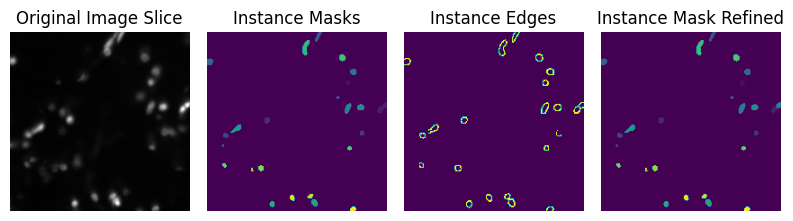

In [30]:
# show image and masks
slice_id = 100

plt.figure(figsize=(8, 4))
plt.subplot(1, 4, 1)
plt.imshow(imgs[slice_id].cpu().numpy(), cmap="gray")
plt.title("Original Image Slice")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(segmentation.relabel_sequential(mask_preds[slice_id])[0])
plt.title(f"Instance Masks")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(edge_preds[slice_id])
plt.title(f"Instance Edges")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(segmentation.relabel_sequential(mask_int[slice_id])[0])
plt.title(f"Instance Mask Refined")
plt.axis("off")

plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.1)

plt.show()